In [ ]:
# Load libraries
import math
import sys
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import pywt
from scipy.io import loadmat, savemat
from scipy import signal
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow as tf
import keras.backend as K
from keras.models import Sequential,  Model
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Bidirectional, Input
from keras.layers import MaxPooling2D, Conv2D, MaxPooling1D, Conv1D, Dense, Flatten, AveragePooling1D, LSTM, Dropout, Input, Concatenate, LeakyReLU, BatchNormalization, Activation
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from google.colab import files
from numpy import savetxt
from keras.layers import Layer

In [ ]:
# ==== Reproducibility Setup ====
import os
import random

seed = 0  # You can change this to any integer to control the seed globally

# Set seeds for reproducibility
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Enable deterministic operations (may reduce speed slightly)
tf.config.experimental.enable_op_determinism()
# =================================

# Create a seeded initializer to ensure consistent weights
initializer = tf.keras.initializers.GlorotUniform(seed=seed)


In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load data
data1 = loadmat('/content/drive/My Drive/Colab Notebooks/Entire_Signal/CNN_With_Spectra/Data/Spectrum.mat')
xdf = pd.DataFrame(data1['Spectrum'])

data2 = loadmat('/content/drive/My Drive/Colab Notebooks/Entire_Signal/CNN_With_Spectra/Data/ShearStress.mat')
# Flatten the ShearStress array before creating the DataFrame
ydf = pd.DataFrame({'ShearStress':data2['ShearStress'].flatten()})
print(xdf)
print(ydf)

            0            1            2            3            4    \
0        9341.0  5582.167200  2117.748519  3578.356069  2076.119974   
1        8723.0  5532.404058  1703.253320  4267.454317  2860.252019   
2       10639.0  6931.829364  1651.339486  3529.215081  1869.449960   
3       10012.0  5761.836738  2358.984077  4158.084097  2057.142419   
4        8499.0  5537.198814   822.102292  3561.576159  1667.505687   
...         ...          ...          ...          ...          ...   
132401  11330.0  7110.622755  3006.683228  4745.904803  2707.766131   
132402  10831.0  7217.994138  3091.481547  5360.107324  2737.621280   
132403  11280.0  7358.656547  2127.765266  5078.274751  3559.578345   
132404  12934.0  7625.471124  3658.703967  5792.009028  3381.831345   
132405  13207.0  7182.031084  3831.784116  4732.954649  4877.546543   

                5            6            7            8            9    ...  \
0       5439.013006  3991.316783  1674.343553  2999.175885  3031.77

In [ ]:
del data1, data2

In [ ]:
# Split data in train-val-test (72-8-20)
x_train, x_test1, y_train, y_test = train_test_split(xdf, ydf, test_size=0.2, shuffle=False)
X_train1, X_val1, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.125, shuffle=False)

del x_train, y_train

In [ ]:
# Reshape data & scaling
X_train = np.reshape(X_train1.values, (-1,1))
X_val = np.reshape(X_val1.values, (-1,1))
x_test = np.reshape(x_test1.values, (-1,1))

del X_train1, X_val1, x_test1

sc = MinMaxScaler(feature_range=(0,1))
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
x_test = sc.transform(x_test)

X_train = np.reshape(X_train, (-1,105))
X_val = np.reshape(X_val, (-1,105))
x_test = np.reshape(x_test, (-1,105))

print(X_train.shape, X_val.shape, x_test.shape)
print(Y_train.shape, Y_val.shape,y_test.shape)

(92683, 105) (13241, 105) (26482, 105)
(92683, 1) (13241, 1) (26482, 1)


In [ ]:
# Reshape in the tensor form
X_train = np.reshape(np.array(X_train), (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(np.array(X_val), (X_val.shape[0], X_val.shape[1], 1))
x_test = np.reshape(np.array(x_test), (x_test.shape[0], x_test.shape[1], 1))
print(X_train.shape, X_val.shape, x_test.shape)

(92683, 105, 1) (13241, 105, 1) (26482, 105, 1)


In [ ]:
# Input Signal
inp = Input(shape=(105, 1), name='inp')

# CNN 1:
conv1 = Conv1D(16, kernel_size=9, kernel_initializer=initializer)(inp)
bn1 = BatchNormalization()(conv1)
act1 = Activation(LeakyReLU())(bn1)
pool1 = MaxPooling1D(pool_size=4, strides=2)(act1)

# CNN 2
conv2 = Conv1D(8, kernel_size=7, kernel_initializer=initializer)(pool1)
bn2 = BatchNormalization()(conv2)
act2 = Activation(LeakyReLU())(bn2)
pool2 = MaxPooling1D(pool_size=4, strides=2)(act2)

# CNN 3
conv3 = Conv1D(4, kernel_size=5, kernel_initializer=initializer)(pool2)
bn3 = BatchNormalization()(conv3)
act3 = Activation(LeakyReLU())(bn3)
pool3 = MaxPooling1D(pool_size=4, strides=2)(act3)

# CNN 4
conv4 = Conv1D(2, kernel_size=3, kernel_initializer=initializer)(pool3)
bn4 = BatchNormalization()(conv4)
act4 = Activation(LeakyReLU())(bn4)
pool4 = MaxPooling1D(pool_size=4, strides=2)(act4)

# Extract Features
f2 = Flatten(name='Features')(pool4)

# Regression
op = Dense(1, activation='linear', kernel_initializer=initializer)(f2)

# Model
model = Model(inputs=[inp], outputs=[op])
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inp (InputLayer)                │ (None, 105, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 97, 16)         │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 97, 16)         │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 97, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 47, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 41, 8)          │           904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 41, 8)          │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 41, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 19, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 15, 4)          │           164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 15, 4)          │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 15, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, 6, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 4, 2)           │            26 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 4, 2)           │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 4, 2)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_16 (MaxPooling1D) │ (None, 1, 2)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Features (Flatten)              │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,377 (5.38 KB)

 Trainable params: 1,317 (5.14 KB)

 Non-trainable params: 60 (240.00 B)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['inp']
Received: inputs=Tensor(shape=(None, 105, 1))
  warnings.warn(msg)


2896/2897 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.2325

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['inp']
Received: inputs=Tensor(shape=(None, 105, 1))
  warnings.warn(msg)



Epoch 1: val_loss improved from inf to 0.47995, saving model to /content/drive/My Drive/Colab Notebooks/Entire_Signal/CNN_With_Spectra/Check1.keras
2897/2897 ━━━━━━━━━━━━━━━━━━━━ 38s 10ms/step - loss: 8.2287 - val_loss: 0.4799
Epoch 2/50
2895/2897 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0081
Epoch 2: val_loss did not improve from 0.47995
2897/2897 ━━━━━━━━━━━━━━━━━━━━ 40s 10ms/step - loss: 0.0081 - val_loss: 0.4815
Epoch 3/50
2895/2897 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0061
Epoch 3: val_loss did not improve from 0.47995
2897/2897 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - loss: 0.0061 - val_loss: 0.8815
Epoch 4/50
2895/2897 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0053
Epoch 4: val_loss did not improve from 0.47995
2897/2897 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - loss: 0.0053 - val_loss: 0.9737
Epoch 5/50
2896/2897 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0048
Epoch 5: val_loss did not improve from 0.47995
2897/2897 ━━━━━━━━━━━━━━━━━━━━ 30s 10ms/step - loss: 0.0048 - val_loss:

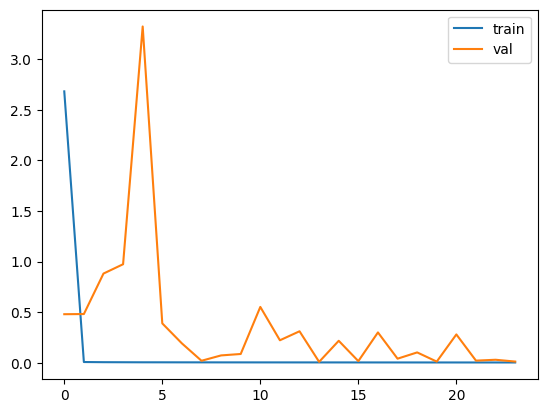

---Training time: 880.05483317 seconds ---


In [ ]:
# Model: compile, summary & fit
model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10,verbose=1, mode='auto')  #Stops when accuracy is no longer changing
checkpoint = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/Entire_Signal/CNN_With_Spectra/Check1.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')  #Saves best model so far, add .keras extension to the file name
callbacks_list = [earlystop, checkpoint]
start_time = time.time()
history = model.fit(X_train, Y_train, batch_size=32, epochs=50, verbose=1, callbacks=callbacks_list, validation_data=(X_val, Y_val))
end_time = time.time()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()
print("---Training time: %0.8f seconds ---" % (end_time - start_time))

In [ ]:
# Evaluate the model

# Training
y_predTrain = model.predict(X_train)
y_predTrain = pd.DataFrame(y_predTrain)
train_r2 = r2_score(Y_train, y_predTrain)
train_rmse = np.sqrt(mean_squared_error(Y_train, y_predTrain))

# #Validation
y_predVal = model.predict(X_val)
y_predVal = pd.DataFrame(y_predVal)
val_r2 = r2_score(Y_val, y_predVal)
val_rmse = np.sqrt(mean_squared_error(Y_val, y_predVal))

# # Testing
start_time = time.time()
y_predTest = model.predict(x_test)
y_predTest = pd.DataFrame(y_predTest)
end_time = time.time()
test_r2 = r2_score(y_test, y_predTest)
test_rmse = np.sqrt(mean_squared_error(y_test, y_predTest))

# Print scores
print("R^2 scores: ", train_r2, val_r2, test_r2)
print("RMSE: ", train_rmse, val_rmse, test_rmse)
# print("\n---Time for Test data prediction: %0.8f seconds ---" % (end_time - start_time))

   1/2897 ━━━━━━━━━━━━━━━━━━━━ 14:10 294ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['inp']
Received: inputs=Tensor(shape=(32, 105, 1))
  warnings.warn(msg)


2897/2897 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
828/828 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
R^2 scores:  0.6640286700783515 0.44122243955412366 -0.4006991736472525
RMSE:  0.07401417309716538 0.10984071457298039 0.17138104448203037


   1/2897 ━━━━━━━━━━━━━━━━━━━━ 11:32 239ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['inp']
Received: inputs=Tensor(shape=(32, 105, 1))
  warnings.warn(msg)


2897/2897 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['inp']
Received: inputs=Tensor(shape=(None, 105, 1))
  warnings.warn(msg)


2897/2897 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step
(92683, 2)


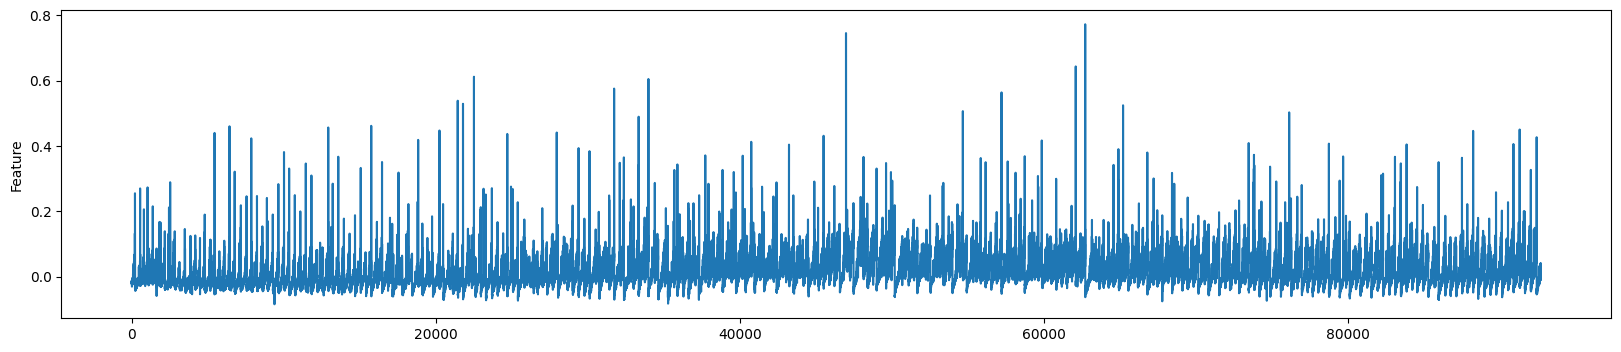

In [ ]:
# Extracted features (training set)
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('Features').output)
intermediate_output_train = intermediate_layer_model.predict(X_train)
print(intermediate_output_train.shape)
for i in range(0,intermediate_output_train.shape[1], 2):
  fig = plt.figure(i, figsize=(20,4))
  mc = pd.DataFrame(intermediate_output_train[:,i])
  plt.plot(mc)
  plt.ylabel('Feature')

414/414 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
(13241, 2)


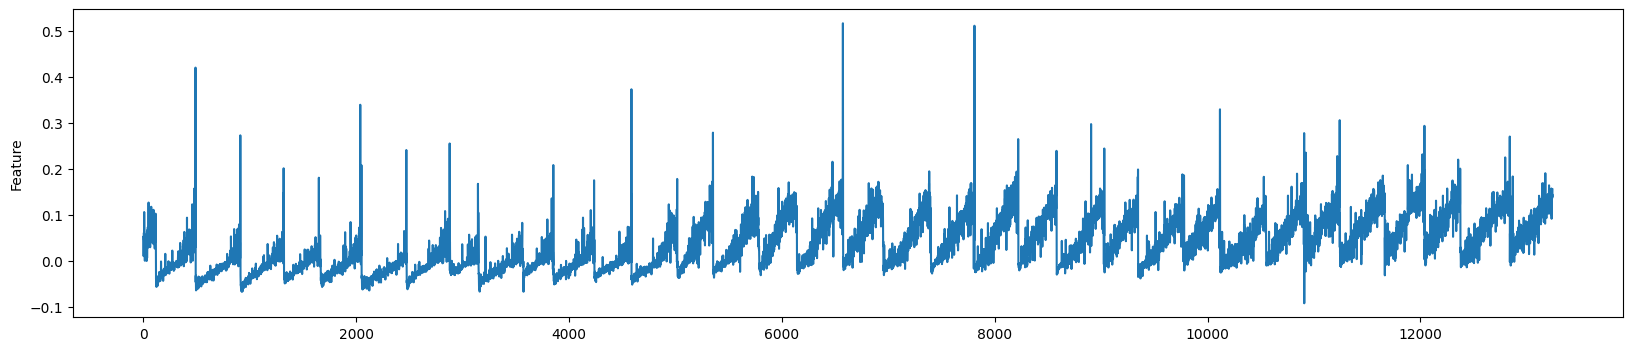

In [ ]:
# Extracted features (validation set)
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('Features').output)
intermediate_output_val = intermediate_layer_model.predict(X_val)
print(intermediate_output_val.shape)
for i in range(0,intermediate_output_val.shape[1], 2):
  fig = plt.figure(i, figsize=(20,4))
  mc = pd.DataFrame(intermediate_output_val[:,i])
  plt.plot(mc)
  plt.ylabel('Feature')

828/828 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
(26482, 2)


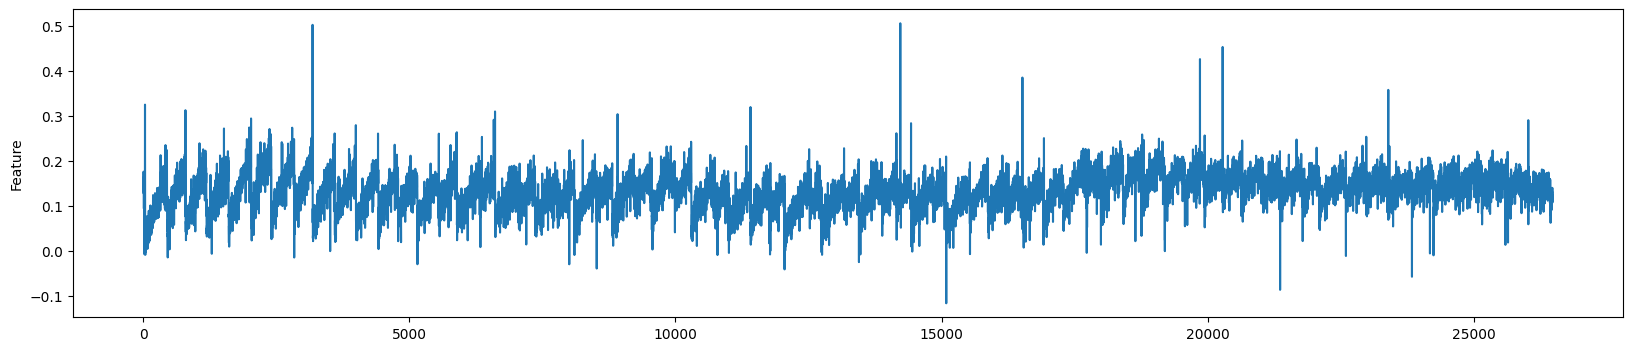

In [ ]:
# Extracted features (test set)
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('Features').output)
intermediate_output_test = intermediate_layer_model.predict(x_test)
print(intermediate_output_test.shape)
for i in range(0,intermediate_output_test.shape[1], 2):
  fig = plt.figure(i, figsize=(20,4))
  mc = pd.DataFrame(intermediate_output_test[:,i])
  plt.plot(mc)
  plt.ylabel('Feature')

In [ ]:
 # combine Features
Amp_Feature = np.vstack((intermediate_output_train, intermediate_output_val, intermediate_output_test))
print(Amp_Feature.shape)

(132406, 2)


In [ ]:
# Output
ydf_new = ydf.to_numpy()
print(ydf_new.shape)

(132406, 1)


In [ ]:
# Preprocessing (SS)
df_SS = np.hstack((Amp_Feature, ydf_new))
print(df_SS.shape)

(132406, 3)


In [ ]:
savetxt('Features_SS.csv', df_SS, delimiter=',')
files.download('Features_SS.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>